#### This notebook was designed to utilized as a short presentation with optional code view. In github, it renders as a static page.

#### Link to dataset utilized: https://www.consumerfinance.gov/data-research/consumer-complaints/

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<button style="Height:50px;font-size:24px" onclick="code_toggle()">View Code</button>''')

# How can we build complaint analytics to help determine what matters to our customers?

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import re
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def dateLookup(s):
    """
    Memoization solution for faster date_time parsing
    source: https://stackoverflow.com/questions/29882573/pandas-slow-date-conversion
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

def remove_redact(text):
    return re.sub('XX/?','',text)

def bow_vectorize(text_series,max_df):
    cv = CountVectorizer(stop_words='english',min_df=0.01,max_df=max_df,ngram_range=(1,6), max_features = 15000)
    m = cv.fit_transform(text_series)
    return {'cv':cv,'m':m}

def bow_conform(text_series,feature_names):
    cv = CountVectorizer(stop_words='english',ngram_range=(1,6), max_features = 15000, vocabulary = feature_names)
    m = cv.fit_transform(text_series)
    return {'cv':cv,'m':m}

def tfidf_vectorize(bow_m,sublinear_tf):
    tt = TfidfTransformer(norm='l2',smooth_idf=True,use_idf=True,sublinear_tf=sublinear_tf)
    m = tt.fit_transform(bow_m)
    return {'tt':tt,'m':m}


In [3]:
c = pd.read_csv('../Consumer_Complaints.csv')

#Take subset where complaint text is available
c = c[c['Consumer consent provided?'] == 'Consent provided']

#Convert yes/no strings to bool
for col in ['Consumer disputed?','Timely response?']:
    c[col] = (c[col] == 'Yes')
    
#Convert datetimes    
for col in ['Date received', 'Date sent to company']:
    c[col] = dateLookup(c[col])
    
#All complaints in our subset are submitted via web and have consent provided.
c = c.drop(['Consumer consent provided?','Submitted via'],axis='columns')

#Convert all others, convert yes/no bools to int64
dataTypes = {
    'Product':'category',
    'Sub-product':'category',
    'Issue':'category',
    'Sub-issue':'category',
    'Consumer complaint narrative':str,
    'Company public response':str,
    'Company':'category',
    'State':'category',
    'ZIP code':str,
    'Tags':str,
    'Company response to consumer':'category',
    'Timely response?':'int64',
    'Consumer disputed?':'int64',
    'Complaint ID':'int64'
}

c = c.astype(dataTypes)

columnNames = {
    'Date received':'date_received',
    'Product':'product',
    'Sub-product':'sub_product',
    'Issue':'issue',
    'Sub-issue':'sub_issue',
    'Consumer complaint narrative':'text',
    'Company public response':'pub_reply',
    'Company':'company',
    'State':'state',
    'ZIP code':'zip_code',
    'Tags':'tags',
    'Date sent to company':'date_sent',
    'Company response to consumer':'cust_reply',
    'Timely response?':'timely_reply',
    'Consumer disputed?':'disputed',
    'Complaint ID':'ID'
}

c = c.rename(columns = columnNames)

b = c[c['product'] == 'Bank account or service'].copy()

#There are a few missing state entries, and not every complaint has a sub-product or sub-issue.

#Cleaning Up for Word Vectorization.
#Remove XXXXs
#Are numbers significant/helpful? Is there another format that might make them moreso?
#Strings of XXXX are used for redaction. These will need to be removed.

b.loc[:,'clean_text'] = b['text'].apply(remove_redact)

issueAliases = {
    'Account opening, closing, or management':'Account',
    'Deposits and withdrawals':'Transactions',
    'Making/receiving payments, sending money':'Payments',
    'Problems caused by my funds being low':'Low Funds',
    'Using a debit or ATM card':'Card'
}

b['issue'] = b['issue'].map(issueAliases).copy()

issues = sorted(list(issueAliases.values()))

## We'd like to have analytics on customer feedback.

Customers are constantly providing feedback that could be of great value in prioritizing which issues to address first. We can overcome the bias in anecdotal summaries of this feedback by seeing how much each issue is actually written about and how each issue has trended over time. Here's an example of what those displays could tell us, based on complaint data about Banking Services from the Consumer Financial Protection Bureau:

### A simple bar chart tells us what people are talking about most

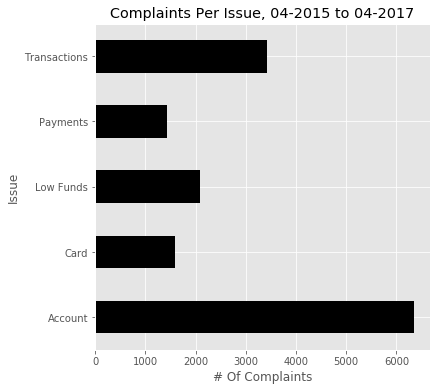

In [4]:
p_issue_class = b.groupby(['product','issue'])['text'].count()
p_issue_class['Bank account or service'].plot(kind='barh',title = 'Complaints Per Issue, 04-2015 to 04-2017',color='black',figsize=(6,6))
plt.xlabel('# Of Complaints')
plt.ylabel('Issue')
plt.show()
    

### Alternatively, the way these issues have trended tell us if the issue's importance is rising, stable, or declining.

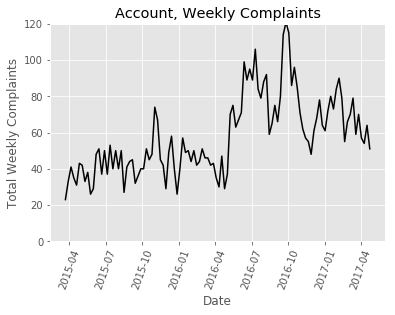

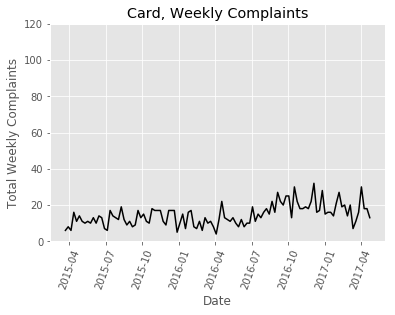

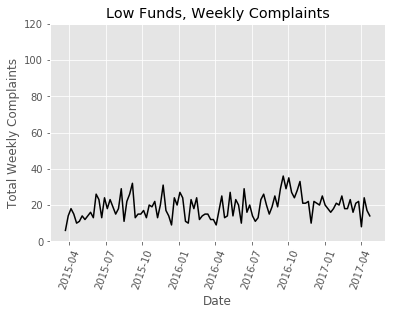

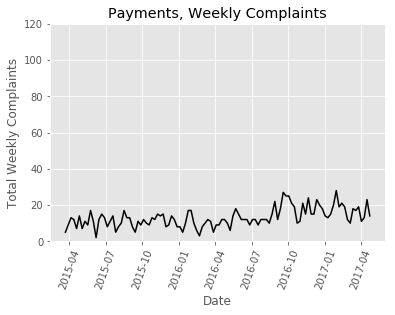

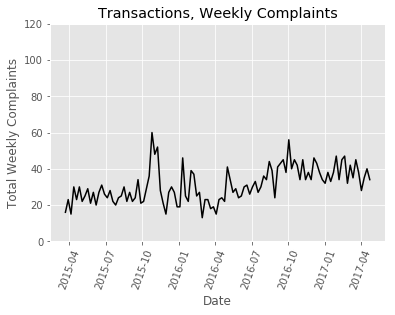

In [5]:
a = b
a.index = b['date_received']
issue_counts = {issue:a[a['issue'] == issue]['issue'].resample('W').count() for issue in issues}
for issue, series in issue_counts.items():
    plt.plot(series,color='black')
    plt.title(issue + ', Weekly Complaints')
    plt.xticks(rotation=70)
    plt.ylim(0,120)
    plt.ylabel('Total Weekly Complaints')
    plt.xlabel('Date')
    plt.show()


## What is the fastest and most reliable way for us to classify the issues in our own complaint data?

Labeling every ticket by hand costs human labor. Can an algorithm learn to label the issue addressed in each message, based on a handful of human-labeled examples? 

Since a human could definitely infer the issue addressed in each message by reading it, we can intuit that the text contains enough information to accurately predict the issue. This will depend largely on our ability to create **seperable categories**, which we can tell apart based on **quantifiable features** derived from the text. We'll then need to find a classification algorithm that latches onto those distinctions without being overzealous.

We'll reduce the information contained in the language of each ticket to a matrix with features, labels and observations. The features will be quantifiable aspects of that message, the labels will be the human-labeled issue, and each message will be an observation.

The most prevalent technique for extracting features from text is a "Bag of Words" matrix that shows how many time each phrase occured in a document. However, the phrases we're especially interested are those that are very commonly stated about a specific topic and very rarely stated about other topics. 

The presence of such phrases should be predictive of the issue, especially when they co-occur. Conversely, we'll have plenty of generic phrases which are common across tickets or appear too rarely to be helpful.

Let's find out what the distribution of specific vs non-specific terms looks like. To do this we'll use a metric formally called TFIDF, designed to measure term specificity. TFIDF balances how often a term occurs in a particular issue against how often it occurs in general. To help us remember what we're talking about, we'll just refer to it as term specificity.

### Specific terms in the text content for each issue are far outnumbered by generic terms.

In [6]:
# We'll take a representive sampling of each issue's text.

np.random.seed(0)
issue_sample_size = 500;
issue_text_samples = {i:b[b['issue'] == i].sample(issue_sample_size)['clean_text'].reset_index(drop=True) for i in issues}
text_globs = pd.Series({i:' '.join(issue_text_samples[i]) for i in issues},index = issues)


In [7]:
glob_bow = bow_vectorize(text_globs,max_df=1.0)
#Computes sublinear tf, in which term frequency is replaced with 1 + log(tf), functions better for Doc Count.
glob_tfidf = tfidf_vectorize(glob_bow['m'],sublinear_tf=True)

In [8]:
bow_m = glob_bow['m'].todense()
tfidf_m = glob_tfidf['m'].todense()
feature_names = glob_bow['cv'].get_feature_names()
metrics = ['bow','tfidf']
comp_m = np.concatenate([row for i in range(bow_m.shape[0]) for row in 
                         [bow_m[i,:],tfidf_m[i,:]]
                        ])
comp_index = pd.MultiIndex.from_product([issues,metrics], names=['Issue', 'Metric'])
feature_index = pd.Index(feature_names,name='Features')
glob_df = pd.DataFrame(comp_m.T,index=feature_index, columns=comp_index)


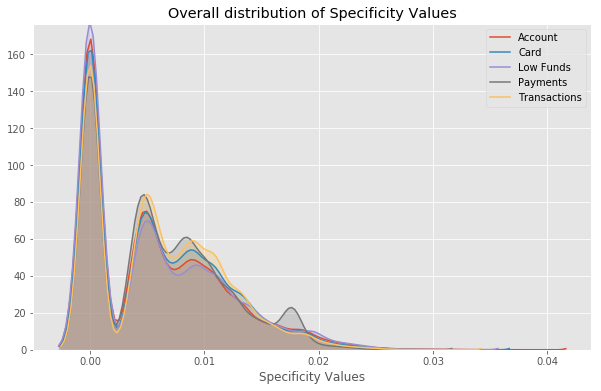

In [9]:
plt.figure(figsize=(10,6))
plt.title("Overall distribution of Specificity Values")
for issue in issues:
    sns.kdeplot(glob_df.loc[:,(issue,'tfidf')],shade=True,label=issue)
plt.xlabel('Frequency')
plt.xlabel('Specificity Values')
plt.show()

### Let's take a look at a few of the most and least specific terms for each issue.

In [10]:
np.random.seed(47)

for issue in issues:
    print()
    print('\033[1m' + issue + ' Issues' + '\033[0m','\n')
    it = glob_df.loc[:,(issue,['tfidf','bow'])]
    it.columns = it.columns.get_level_values(1)
    it.columns = ["Frequency","Specificity"]
    unigrams = it.loc[[i for i in glob_df.index if len(i.split(' ')) == 1]].sort_values(by='Specificity',ascending=False)
    bigrams = it.loc[[i for i in glob_df.index if len(i.split(' ')) == 2]].sort_values(by='Specificity',ascending=False)
    it = it.sort_values(by=['Specificity'],ascending=False)
    print('One Word Phrases')
    print(unigrams.head(15))
    print()
    print('Two Word Phrases')
    print(bigrams.head(10))
    print()


Account Issues 

One Word Phrases
            Frequency  Specificity
Features                          
aadvantage       43.0     0.037108
promotion       223.0     0.033443
promo            26.0     0.033187
account        1871.0     0.031694
bank           1116.0     0.029775
thankyou         15.0     0.028900
apy              15.0     0.028900
cp               14.0     0.028362
citigold         69.0     0.027320
00              534.0     0.027038
told            439.0     0.026310
credit          413.0     0.026084
qualifying       10.0     0.025740
checking        367.0     0.025645
did             314.0     0.025066

Two Word Phrases
                        Frequency  Specificity
Features                                      
met requirements             54.0     0.038883
citigold checking            38.0     0.036145
completed requirements       25.0     0.032881
bonus miles                  24.0     0.032563
aadvantage miles             23.0     0.032231
opened citigold        

### We'll need a good strategy for handling numeric values

The above examples illustrate that numeric values play a peculiar role in our extracted terms. If we transform these into ranges that capture the way they are being uses, these features might retain their specificity whilst becoming more prevalent within the issue as a whole. For example, 34 and 35 dollar fees are popular terms in 'Low Funds' that can be aggregated.

### Depending on the problem framing, we may want to remove certain proper nouns.

Names of banks in the CDFI data set that this project utilizes may not be realistic terms to consider, depending on the project's final framing of client + issue.

### How would a classifier do with predicting the topic based on these collections of terms?

A multinomial bayes classifier, based on a straight forward extension of Baye's theorem, was trained to predict the issue based on the term specificity scores for the words in each document.

The heatmap matrix below illustrates the classifier's ability to distinguish between various classes. 

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [12]:
example_set = b.reset_index(drop=True)[['clean_text','issue']]

In [13]:
#assemble training examples and labels for unbalanced set
#Make the vocabulary correspond to the one learned from the topic globs.
examples_bow = bow_conform(example_set['clean_text'],feature_names)
examples_tfidf = tfidf_vectorize(examples_bow['m'],sublinear_tf=True)
labels = example_set['issue']

In [14]:
#Take a balanced sampling for an alternative training set and an unbalanced/stratified test set
np.random.seed(42)

class_balance = np.array([len(example_set[example_set['issue'] == issue]) for issue in issues])

es_copy = example_set.copy()
training_samples = []
test_samples = []
smallest_class_total = np.min(class_balance)
test_frac = 0.33
training_size = int(np.floor(smallest_class_total*(1-test_frac)))
min_test_size = smallest_class_total-training_size
test_sample_sizes = zip(issues,np.floor(class_balance*(min_test_size/smallest_class_total)))

for issue in issues:
    training_samples.append(es_copy[es_copy['issue'] == issue].sample(training_size,replace=False))
bal_training_set = pd.concat(training_samples)

es_copy = es_copy.drop(bal_training_set.index)
overlap_test=set(es_copy.index).intersection(set(bal_training_set.index))

for issue,test_size in test_sample_sizes:
    test_samples.append(es_copy[es_copy['issue'] == issue].sample(int(test_size),replace=False))
strat_test_set = pd.concat(test_samples)
    

In [15]:
#assemble training examples and labels for balanced set
#Make the vocabulary correspond to the one learned from the topic globs.

bal_training_bow = bow_conform(bal_training_set['clean_text'],feature_names)
bal_training_tfidf = tfidf_vectorize(bal_training_bow['m'],sublinear_tf=True)
bal_training_labels = bal_training_set['issue']

strat_test_bow = bow_conform(strat_test_set['clean_text'],feature_names)
strat_test_tfidf = tfidf_vectorize(strat_test_bow['m'],sublinear_tf=True)
strat_test_labels = strat_test_set['issue']

bal_X_train,bal_y_train = bal_training_tfidf['m'], bal_training_labels
strat_X_test, strat_y_test = strat_test_tfidf['m'], strat_test_labels

In [16]:
#train a multinomial bayes classifier for both sets
bal_mnb_classifier = MultinomialNB()
bal_mnb_classifier.fit(X=bal_X_train,y=bal_y_train)
print()

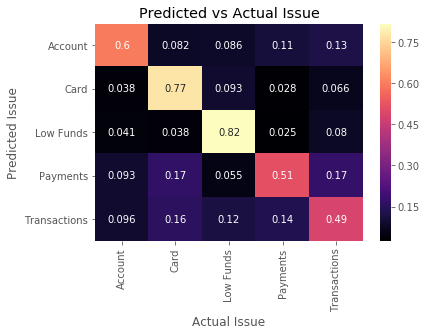

              precision    recall  f1-score   support

     Account       0.86      0.60      0.71      2095
        Card       0.47      0.77      0.59       527
   Low Funds       0.59      0.82      0.68       688
    Payments       0.37      0.51      0.43       472
Transactions       0.56      0.49      0.52      1130

 avg / total       0.67      0.61      0.62      4912

Num of training examples : [ 960.  960.  960.  960.  960.]


In [17]:
predictions = bal_mnb_classifier.predict(X=strat_X_test)
confusion = np.matrix(metrics.confusion_matrix(strat_y_test,predictions))
rel_confusion = confusion/confusion.sum(axis=1)
rc_df = pd.DataFrame(rel_confusion,index=issues,columns=issues)
heat = sns.heatmap(rc_df,cmap='magma',annot=True)
heat.set(xlabel = 'Actual Issue',ylabel = 'Predicted Issue',title= 'Predicted vs Actual Issue')
plt.show()
print(metrics.classification_report(strat_y_test,predictions))
print('Num of training examples :',bal_mnb_classifier.class_count_)

### Final Thoughts

As you can see above, some issues are easier to predict than others, and certain pairs seem to blend together. One possible explanation for this is that specific language is not consistently used. With our further feature engineering efforts, we'll try to find generalizable signifiers that are both widely distributed and unique to the issue.

Our model of term specificity presents an interesting issue in practice since we're classifying a single new document rather than a new large corpus of documents. In order to take the advantage of context, we will utilize the Inverse Document Frequency metric from our training data to weight the Term Frequency of the test data. Normally the Term Frequency and Inverse Document Frequency would be computed based on the same corpus. This should help weigh the features in such a way that topic-specific phrases are emphasized.

**Based on the above, we can see that a more developed classifier may be able to parse these categories in a majority of cases. However, if specific terms aren't prevalent enough in a message, our algorithm could ask for human help.** This means that a reliable metric of confidence will play an important role in getting this algorithm to avoid the mis-classifications evident in the heatmap above.

We will also want to explore non-supervised 'topic modeling' methods to help us deal with an initial stack of unsorted topics. In this phase, we could verify that the categories we use for classification are seperable to an algorithm as well as meaningful to a person.